In [11]:
import sys
import os
import sys
import os
# Add the parent directory of TRVQA to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from TRVQA.measure.enums import MeasureMethod
from TRVQA.optimization.gradients.vanilla_parameter_shift import vanilla_parameter_shift
from TRVQA.optimization.optimization import minimize, minimize_custom
from TRVQA.utils.maxcut import gengraph, create_hamiltonian, make_hamiltonian
import torch
from torch.autograd import Function
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit import QuantumCircuit

import numpy as np
import torch
from TRVQA.circuit import Circuit

def compute_maxcut_value(bitstring, graph):
    """Computes the MaxCut value for a given bitstring solution."""
    cut_value = sum(w for (u,v), w in graph if bitstring[u] != bitstring[v])
    return cut_value

# for s in best_value:
#     print(compute_maxcut_value(s, g))

from pyparsing import Optional
import torch
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from TRVQA.optimization.optimization import minimize, minimize_custom
# TRVQA imports

from TRVQA.circuit import Circuit
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
from TRVQA.measure.enums import MeasureMethod
torch.cuda.empty_cache()
import numpy as np
import torch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
import torch

from TRVQA.measure.enums import MeasureMethod
from TRVQA.optimization.optimization import minimize
from TRVQA.utils.maxcut import gengraph, create_hamiltonian,make_hamiltonian
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
import numpy as np
import torch
from TRVQA.circuit import Circuit
import time


In [12]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx

def maxcut_value(G) -> float:
    """
    Solve weighted Max-Cut on an undirected NetworkX graph using Gurobi.

    Args:
        G: networkx.Graph
           Undirected graph. Edge weights read from attribute 'weight' (default 1.0).

    Returns:
        float: Optimal Max-Cut value.
    """
    # if not isinstance(G, nx.Graph) or G.is_directed():
    #     raise ValueError("G must be an undirected networkx.Graph")

    model = gp.Model("MaxCut")
    model.Params.OutputFlag = 0  # silence solver output

    # Binary variable x[i] ∈ {0,1} indicates partition side of node i
    #nodes = list(G.nodes())
    # Number of nodes
    nodes = set()
    for e,w in G:
        u,v = e
        nodes.add(u)
        nodes.add(v)
    n = len(nodes)

    x = model.addVars(nodes, vtype=GRB.BINARY, name="x")
    # Objective: Maximize the cut value
    model.setObjective(
        gp.quicksum(w * (x[u] + x[v] - 2 * x[u] * x[v]) for (u, v), w in G),
        GRB.MAXIMIZE
    )

    # Optimize the model
    model.optimize()


    if model.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Gurobi did not find an optimal solution (status={model.Status}).")

    return float(model.ObjVal)


In [13]:
import json
with open("experiment_grid.json", "r") as f:
    loaded = json.load(f)

# Convert lists back to tuples if you want
def convert_lists_to_tuples(obj):
    if isinstance(obj, list):
        # Check if list looks like an edge [(0,1), w]
        if len(obj) == 2 and isinstance(obj[0], list) and isinstance(obj[1], (int, float)):
            return (tuple(obj[0]), obj[1])
        else:
            return [convert_lists_to_tuples(x) for x in obj]
    if isinstance(obj, dict):
        return {k: convert_lists_to_tuples(v) for k, v in obj.items()}
    return obj

exp_grid_loaded = [convert_lists_to_tuples(entry) for entry in loaded]

print(exp_grid_loaded[0])  # should match your original structure
# {'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


{'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


In [14]:
# =========================
# Reading + Plotting Utils
# =========================
import os, csv, json
from typing import List, Dict, Any, Tuple
import torch
import matplotlib.pyplot as plt

# ---------- Readers ----------
def read_summary(summary_csv: str = "bench_out/summary.csv") -> List[Dict[str, Any]]:
    """
    Returns a list of dict rows:
      run_id, method, N, seed, theta_path, iter_csv
    """
    rows = []
    with open(summary_csv, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            row["N"] = int(row["N"])
            row["seed"] = int(row["seed"])
            rows.append(row)
    return rows

def read_iter_csv(run_id: str, outdir: str = "bench_out") -> Dict[str, List[Any]]:
    """
    Reads per-iteration CSV for a single run and returns:
      {"iter": [...], "exp_values": [...], "best_results": [...], "iter_times": [...]}
    """
    path = os.path.join(outdir, f"iter_{run_id}.csv")
    iters, exp_values, best_results, iter_times = [], [], [], []
    with open(path, "r") as f:
        r = csv.DictReader(f)
        for row in r:
            iters.append(int(row["iter"]))
            exp_values.append(float(row["exp_value"]))
            best_results.append(json.loads(row["best_result"]))
            iter_times.append(float(row["iter_time"]) if row["iter_time"] else None)
    return {
        "iter": iters,
        "exp_values": exp_values,
        "best_results": best_results,
        "iter_times": iter_times,
    }

def load_theta(run_id: str, outdir: str = "bench_out") -> torch.Tensor:
    """Loads final_theta tensor saved as theta_<run_id>.pt"""
    theta_path = os.path.join(outdir, f"theta_{run_id}.pt")
    return torch.load(theta_path, map_location="cpu")

# ---------- Small helpers ----------
def running_min(seq: List[float]) -> List[float]:
    mn, out = float("inf"), []
    for x in seq:
        mn = x if x < mn else mn
        out.append(mn)
    return out

def cumulative_sum(seq: List[float]) -> List[float]:
    total, out = 0.0, []
    for x in seq:
        if x is None:  # keep shape sane even if some iter_times weren’t tracked
            out.append(total)
        else:
            total += float(x)
            out.append(total)
    return out

# ---------- Plots: single run ----------
def plot_loss_vs_iter(run_id: str, outdir: str = "bench_out", *, show_running_min: bool = True):
    data = read_iter_csv(run_id, outdir)
    it = data["iter"]; ev = data["exp_values"]
    plt.figure(figsize=(7,4))
    plt.plot(it, ev, label="loss (⟨H⟩)")
    if show_running_min:
        plt.plot(it, running_min(ev), linestyle="--", label="running min")
    plt.xlabel("iteration"); plt.ylabel("loss")
    plt.title(f"Loss vs Iter (run {run_id})")
    plt.legend(); plt.tight_layout()
    plt.show()

def plot_iter_time(run_id: str, outdir: str = "bench_out"):
    data = read_iter_csv(run_id, outdir)
    it = data["iter"]; tt = data["iter_times"]
    plt.figure(figsize=(7,4))
    plt.plot(it, tt, label="iter time (s)")
    plt.xlabel("iteration"); plt.ylabel("seconds")
    plt.title(f"Iteration Time vs Iter (run {run_id})")
    plt.legend(); plt.tight_layout()
    plt.show()

def plot_cumulative_time(run_id: str, outdir: str = "bench_out"):
    data = read_iter_csv(run_id, outdir)
    it = data["iter"]; tt = data["iter_times"]
    cum = cumulative_sum(tt)
    plt.figure(figsize=(7,4))
    plt.plot(it, cum, label="cumulative time (s)")
    plt.xlabel("iteration"); plt.ylabel("seconds")
    plt.title(f"Cumulative Time vs Iter (run {run_id})")
    plt.legend(); plt.tight_layout()
    plt.show()

# Optional compact dashboard (3 panels)
def plot_dashboard(run_id: str, outdir: str = "bench_out"):
    d = read_iter_csv(run_id, outdir)
    it, ev, tt = d["iter"], d["exp_values"], d["iter_times"]
    cum = cumulative_sum(tt)
    rmin = running_min(ev)

    fig = plt.figure(figsize=(12,9))

    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(it, ev, label="loss")
    ax1.plot(it, rmin, linestyle="--", label="running min")
    ax1.set_xlabel("iteration"); ax1.set_ylabel("loss"); ax1.set_title("Loss vs Iter"); ax1.legend()

    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(it, tt, label="iter time (s)")
    ax2.set_xlabel("iteration"); ax2.set_ylabel("seconds"); ax2.set_title("Iteration Time"); ax2.legend()

    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(it, cum, label="cumulative time (s)")
    ax3.set_xlabel("iteration"); ax3.set_ylabel("seconds"); ax3.set_title("Cumulative Time"); ax3.legend()

    fig.suptitle(f"Run {run_id}")
    fig.tight_layout()
    plt.show()

# ---------- Plots: compare multiple runs ----------
def plot_compare_loss(run_ids: List[str], labels: List[str] | None = None, cut_off_it: int = 0, outdir: str = "bench_out"):
    """
    Overlay loss curves for multiple runs (e.g., different methods).
    """
    labels = labels or run_ids
    plt.figure(figsize=(8,5))
    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)
        plt.plot(d["iter"][:min(cut_off_it, len(d["iter"]))], d["exp_values"][:min(cut_off_it, len(d["iter"]))], label=lab)
    plt.xlabel("iteration"); plt.ylabel("loss")
    plt.title("Loss vs Iter (multiple runs)")
    plt.legend(); plt.tight_layout(); plt.show()

# # ---------- Plots: compare multiple runs ----------
# def plot_compare_best_cut(run_ids: List[str], labels: List[str] | None = None, gurobi_max: float | None = None, g=  None, cut_off_it = 0, outdir: str = "bench_out"):
#     """
#     Overlay best cut values for multiple runs (e.g., different methods).
#     """
#     labels = labels or run_ids
#     plt.figure(figsize=(8,5))
#     x = range(0, cut_off_it)
#     if gurobi_max is not None:
#         plt.plot(x, [gurobi_max]*len(x), linestyle="--", label=f"gurobi max ({gurobi_max})")
#     for rid, lab in zip(run_ids, labels):
#         d = read_iter_csv(rid, outdir)

#         #from bit string to cut value\
#         cut_value= [compute_maxcut_value(s, g) for s in d["best_results"]]

#         plt.plot(d["iter"][:min(cut_off_it, len(d["iter"]))], cut_value[:min(cut_off_it, len(d["iter"]))], label=lab)
#     plt.xlabel("iteration"); plt.ylabel("best cut value")
#     plt.title("Best Cut Value vs Iter (multiple runs)")
#     plt.legend(); plt.tight_layout(); plt.show()

# # ---------- Plots: compare multiple runs ----------
# def plot_compare_best_cut(run_ids: List[str], labels: List[str] | None = None, gurobi_max: float | None = None, g=  None, cut_off_it = 0, outdir: str = "bench_out"):
#     """
#     Overlay best cut values for multiple runs (e.g., different methods).
#     """
#     labels = labels or run_ids
#     plt.figure(figsize=(8,5))
#     x = range(0, cut_off_it)
#     if gurobi_max is not None:
#         plt.plot(x, [gurobi_max]*len(x), linestyle="--", label=f"gurobi max ({gurobi_max})")
#     for rid, lab in zip(run_ids, labels):
#         d = read_iter_csv(rid, outdir)

#         #from bit string to cut value\
#         cut_value= [compute_maxcut_value(s, g) for s in d["best_results"]]

#         plt.plot(d["iter"][:min(cut_off_it, len(d["iter"]))], cut_value[:min(cut_off_it, len(d["iter"]))], label=lab)
#     plt.xlabel("iteration"); plt.ylabel("best cut value")
#     plt.title("Best Cut Value vs Iter (multiple runs)")
#     plt.legend(); plt.tight_layout(); plt.show()

#     import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Optional

def _running_best(seq):
    out, m = [], float("-inf")
    for v in seq:
        m = max(m, v)
        out.append(m)
    return out

def _rolling_avg(seq, window: int = 10):
    """Centered rolling average with window size `window`."""
    if len(seq) == 0:
        return seq
    s = pd.Series(seq)
    return s.rolling(window=window, min_periods=1, center=False).mean().to_numpy()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def _running_best(seq):
    out, m = [], float("-inf")
    for v in seq:
        m = max(m, v)
        out.append(m)
    return out

def _rolling_avg(seq, window: int = 10):
    if len(seq) == 0:
        return seq
    s = pd.Series(seq)
    return s.rolling(window=window, min_periods=1, center=False).mean().to_numpy()

def plot_compare_best_cut(
    run_ids: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    gurobi_max: Optional[float] = None,
    g=None,
    cut_off_it: int = 0,
    outdir: str = "bench_out",
    denoise: str = "rolling",  # 'rolling', 'running_best', 'none'
    rolling_window: int = 10,
    # NEW: filters (used when run_ids is None)
    methods: Optional[List[str]] = None,
    depths: Optional[List[int]] = None,
    N: Optional[int] = None,
    seeds: Optional[List[int]] = None,
):
    """
    Plot best cut values vs iteration with optional noise reduction.
    Use either explicit run_ids or (methods/depths/N/seeds) to auto-select from summary.csv.
    """
    # Auto-select runs if not provided
    if run_ids is None:
        run_ids, auto_labels = select_runs(
            outdir=outdir, methods=methods, depths=depths, N=N, seeds=seeds
        )
        if labels is None:
            labels = auto_labels

    labels = labels or run_ids
    plt.figure(figsize=(8, 5))

    # Gurobi line (only if cut_off_it > 0; otherwise we’ll add later)
    if gurobi_max is not None and cut_off_it > 0:
        x_ref = range(0, cut_off_it)
        plt.plot(x_ref, [gurobi_max] * len(x_ref), linestyle="--", label=f"Gurobi max ({gurobi_max})")

    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)  # expects 'iter' and 'best_result(s)'
        iters = d["iter"].tolist() if not isinstance(d["iter"], list) else d["iter"]
        # Be tolerant to column name 'best_result' vs 'best_results'
        best_col = "best_result" if "best_result" in d else "best_results"
        cuts = [compute_maxcut_value(s, g) for s in d[best_col]]

        # Trim
        if cut_off_it > 0:
            iters = iters[:cut_off_it]
            cuts = cuts[:cut_off_it]

        # Denoise
        if denoise == "running_best":
            y = _running_best(cuts)
        elif denoise == "rolling":
            y = _rolling_avg(cuts, rolling_window)
        else:
            y = cuts

        plt.plot(iters, y, label=lab)

    # If cut_off_it == 0 and gurobi_max is requested, make its x-length sensible
    if gurobi_max is not None and cut_off_it == 0 and run_ids:
        L = min(len(read_iter_csv(r, outdir)) for r in run_ids)
        plt.plot(range(L), [gurobi_max] * L, linestyle="--", label=f"Gurobi max ({gurobi_max})")

    plt.xlabel("Iteration")
    plt.ylabel("Best Cut Value (smoothed)")
    plt.title(f"Best Cut Value vs Iteration ({denoise}; window={rolling_window if denoise=='rolling' else '-'})")
    plt.legend()
    plt.tight_layout()
    plt.show()
# ====== Helpers ======
import pandas as pd
from typing import List, Optional, Tuple

def _read_summary(outdir: str = "bench_out") -> pd.DataFrame:
    return pd.read_csv(f"{outdir}/summary.csv")

def select_runs(
    outdir: str = "bench_out",
    methods: Optional[List[str]] = None,
    depths: Optional[List[int]] = None,
    N: Optional[int] = None,
    seeds: Optional[List[int]] = None,
    limit: Optional[int] = None,
    label_fmt: str = "{method}-d{depth}-s{seed}"
) -> Tuple[List[str], List[str]]:
    """
    Select runs from summary.csv by filters and return (run_ids, labels).
    label_fmt fields allowed (if present in CSV): method, depth, seed, N, run_id.
    Falls back gracefully if a column is missing.
    """
    df = _read_summary(outdir)

    # Robustly handle column names that might or might not exist
    if methods is not None and "method" in df.columns:
        df = df[df["method"].isin(methods)]
    if depths is not None and "depth" in df.columns:
        df = df[df["depth"].isin(depths)]
    if N is not None and "N" in df.columns:
        df = df[df["N"] == N]
    if seeds is not None and "seed" in df.columns:
        df = df[df["seed"].isin(seeds)]

    if df.empty:
        return [], []

    if limit is not None:
        df = df.head(limit)

    # Build labels from available columns
    labels = []
    for _, r in df.iterrows():
        fields = {
            "method": r.get("method", "method"),
            "depth" : r.get("depth", "d?"),
            "seed"  : r.get("seed", "s?"),
            "N"     : r.get("N", "N?"),
            "run_id": r.get("run_id", "run?"),
        }
        labels.append(label_fmt.format(**fields))

    run_ids = df["run_id"].tolist() if "run_id" in df.columns else []
    return run_ids, labels


def plot_compare_best_val_cut(
    run_ids: Optional[List[str]] = None,
    labels: Optional[List[str]] = None,
    gurobi_max: Optional[float] = None,
    g=None,
    cut_off_it: int = 0,
    outdir: str = "bench_out",
    # NEW: filters (used when run_ids is None)
    methods: Optional[List[str]] = None,
    depths: Optional[List[int]] = None,
    N: Optional[int] = None,
    seeds: Optional[List[int]] = None,
):
    """
    Overlay *incremental best* cut values (monotonically non-decreasing) for multiple runs.
    You can provide run_ids directly, or let the function pick runs by filters from summary.csv.
    """
    # Auto-select runs if not provided
    if run_ids is None:
        run_ids, auto_labels = select_runs(
            outdir=outdir, methods=methods, depths=depths, N=N, seeds=seeds
        )
        if labels is None:
            labels = auto_labels

    labels = labels or run_ids
    plt.figure(figsize=(8, 5))

    # Reference line
    if gurobi_max is not None and cut_off_it > 0:
        x = range(0, cut_off_it)
        plt.plot(x, [gurobi_max] * len(x), linestyle="--", label=f"Gurobi max ({gurobi_max})")

    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)

        best_col = "best_result" if "best_result" in d.columns else "best_results"
        cut_value = [compute_maxcut_value(s, g) for s in d[best_col]]

        running_best = []
        current_max = float("-inf")
        seq = cut_value[:cut_off_it] if cut_off_it > 0 else cut_value
        for v in seq:
            current_max = max(current_max, v)
            running_best.append(current_max)

        iters = d["iter"][:len(running_best)]
        plt.plot(iters, running_best, label=lab)

    if gurobi_max is not None and cut_off_it == 0 and run_ids:
        L = min(len(read_iter_csv(r, outdir)) for r in run_ids)
        plt.plot(range(L), [gurobi_max] * L, linestyle="--", label=f"Gurobi max ({gurobi_max})")

    plt.xlabel("Iteration")
    plt.ylabel("Best-so-far Cut Value")
    plt.title(f"Incremental Best Cut Value vs Iteration (≤ {cut_off_it} iters)" if cut_off_it > 0 else "Incremental Best Cut Value vs Iteration")
    plt.legend()
    plt.tight_layout()
    plt.show()



def plot_compare_cumtime(run_ids: List[str], labels: List[str] | None = None, outdir: str = "bench_out"):
    """
    Overlay cumulative time curves for multiple runs.
    """
    labels = labels or run_ids
    plt.figure(figsize=(8,5))
    for rid, lab in zip(run_ids, labels):
        d = read_iter_csv(rid, outdir)
        plt.plot(d["iter"], cumulative_sum(d["iter_times"]), label=lab)
    plt.xlabel("iteration"); plt.ylabel("seconds")
    plt.title("Cumulative Time vs Iter (multiple runs)")
    plt.legend(); plt.tight_layout(); plt.show()

# ---------- Convenience from summary ----------
def find_runs(summary_csv: str, *, method: str | None = None, N: int | None = None, seed: int | None = None) -> List[str]:
    """
    Returns list of run_ids matching filters from summary.csv
    """
    rows = read_summary(summary_csv)
    rids = []
    for r in rows:
        if method is not None and r["method"] != method: continue
        if N is not None and r["N"] != N: continue
        if seed is not None and r["seed"] != seed: continue
        rids.append(r["run_id"])
    return rids


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def aggregate_over_seeds(run_ids, g, cut_off_it, denoise="running_best", rolling_window=10, outdir="bench_out", all_graph=None):
    """
    Return iteration array, median curve and lower/upper band across seeds.
    """
    curves = []
    iters_ref = None
    graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in all_graph}
    for rid in run_ids:
        df = pd.read_csv(f"{outdir}/summary.csv")
        summary = df[df["run_id"] == rid].iloc[0]
        seed = summary["seed"]
        N = summary["N"]
        if all_graph is not None:
            g = graph_lookup[(N, seed)]

        d = read_iter_csv(rid, outdir=outdir)
        best_col = "best_result" if "best_result" in d else "best_results"
        iters = np.array(d["iter"][:cut_off_it])
        maximum_cut = maxcut_value(g)
        cuts = [compute_maxcut_value(s, g)/maximum_cut for s in d[best_col][:cut_off_it]]
        # smoothing
        if denoise == "running_best":
            cuts = np.maximum.accumulate(cuts)
        elif denoise == "rolling":
            cuts = pd.Series(cuts).rolling(rolling_window, min_periods=1).mean().to_numpy()

        curves.append(np.array(cuts))
        if iters_ref is None:
            iters_ref = iters

    # pad curves to same length if needed
    max_len = max(len(c) for c in curves)
    curves = [np.pad(c, (0, max_len - len(c)), constant_values=c[-1]) for c in curves]
    curves = np.vstack(curves)

    median = np.median(curves, axis=0)
    q25 = np.percentile(curves, 25, axis=0)
    q75 = np.percentile(curves, 75, axis=0)
    return iters_ref, median, q25, q75

def plot_compare_best_cut_aggregated(
    method_to_runids: dict,
    labels: dict | None = None,
    gurobi_max: float | None = None,
    g=None,
    cut_off_it: int = 0,
    denoise: str = "running_best",
    rolling_window: int = 10,
    outdir: str = "bench_out",
    all_graph = None
):
    """
    Plot aggregated median + IQR curves across seeds for each method.
    method_to_runids = { "tr_efficient_d1": [seed1, seed2, ...], ... }
    """
    plt.figure(figsize=(8, 5))
    x_ref = range(0, cut_off_it)

    for method, runs in method_to_runids.items():
        iters, med, q25, q75 = aggregate_over_seeds(
            runs, g, cut_off_it, denoise=denoise, rolling_window=rolling_window, outdir=outdir, all_graph=all_graph
        )
        lab = labels.get(method, method) if labels else method
        plt.plot(iters, med, label=lab)
        plt.fill_between(iters, q25, q75, alpha=0.2)  # shaded uncertainty

    plt.xlabel("Iteration")
    plt.ylabel("Best Cut Value")
    plt.title(f"Aggregated across seeds (denoise={denoise})")
    plt.legend()
    plt.tight_layout()
    plt.show()
import pandas as pd
from collections import defaultdict

def get_method_to_runids(
    outdir: str = "bench_out",
    methods: list[str] | None = None,
    depths: list[int] | None = None,
    N: int | None = None,
    seeds: list[int] | None = None,
    optim: list[str] | None = None,
    label_fmt: str = "{method}_d{depth}"
):
    """
    Reads summary.csv and groups run_ids by (method, depth).
    Returns: dict like {"tr_efficient_d1": [...run_ids...]}

    label_fmt controls grouping key — can include:
    {method}, {depth}, {N}, {seed}, {run_id}.
    """
    df = pd.read_csv(f"{outdir}/summary.csv")

    # Filtering
    if methods is not None and "method" in df.columns:
        df = df[df["method"].isin(methods)]
    if depths is not None and "depth" in df.columns:
        df = df[df["depth"].isin(depths)]
    if N is not None and "N" in df.columns:
        df = df[df["N"] == N]
    if seeds is not None and "seed" in df.columns:
        df = df[df["seed"].isin(seeds)]
    if optim is not None and "optimizer" in df.columns:
        df = df[df["optimizer"].isin(optim)]

    grouped = defaultdict(list)
    for _, r in df.iterrows():
        # build label name like "tr_efficient_d1"
        label = label_fmt.format(
            method=r.get("method", "m"),
            depth=r.get("depth", "d"),
            N=r.get("N", "N?"),
            seed=r.get("seed", "s?"),
            run_id=r.get("run_id", "run?"),
            optim=r.get("optimizer", "o?")
        )
        grouped[label].append(r["run_id"])
    return dict(grouped)
import matplotlib.pyplot as plt

def plot_compare_loss_aggregated(
    method_to_runids: dict,
    labels: dict | None = None,
    cut_off_it: int = 0,
    denoise: str = "rolling",
    rolling_window: int = 10,
    ylabel: str = "Loss (energy)",
    title: str = "Loss vs Iteration (aggregated)",
    outdir: str = "bench_out",
    all_graph = None
):
    """
    Aggregated loss plot with median + IQR shading over multiple seeds per method.
    """
    plt.figure(figsize=(8, 5))

    for method, runs in method_to_runids.items():
        iters, med, q25, q75 = aggregate_loss_over_seeds(
            runs, cut_off_it,
            denoise=denoise,
            rolling_window=rolling_window,
            outdir=outdir,
            all_graph=all_graph
        )

        lab = labels.get(method, method) if labels else method
        plt.plot(iters, med, label=lab)
        plt.fill_between(iters, q25, q75, alpha=0.2)

    plt.xlabel("Iteration")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

import numpy as np
import pandas as pd

def aggregate_loss_over_seeds(
    run_ids,
    cut_off_it: int,
    denoise: str = "rolling",    # or "none"
    rolling_window: int = 10,
    outdir: str = "bench_out",
    all_graph = None
):
    """
    Aggregates loss curves across multiple seeds.
    Returns: (iters, median_loss, q25, q75)
    """
    curves = []
    iters_ref = None
    graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in all_graph}
    for rid in run_ids:
        d = read_iter_csv(rid, outdir)
        df = pd.read_csv(f"{outdir}/summary.csv")
        summary = df[df["run_id"] == rid].iloc[0]
        seed = summary["seed"]
        N = summary["N"]
        if all_graph is not None:
            g = graph_lookup[(N, seed)]
        maximum_cut = maxcut_value(g)
        iters = np.array(d["iter"][:cut_off_it])
        losses = np.array(d["exp_values"][:cut_off_it])   # energy or loss
        # losses =  [(maximum_cut-s)/maximum_cut for s in d["exp_values"][:cut_off_it]]
        # Denoise
        if denoise == "rolling":
            losses = pd.Series(losses).rolling(
                rolling_window, min_periods=1
            ).mean().to_numpy()

        curves.append(losses)
        if iters_ref is None:
            iters_ref = iters

    max_len = max(len(c) for c in curves)
    curves = [np.pad(c, (0, max_len - len(c)), constant_values=c[-1]) for c in curves]
    curves = np.vstack(curves)

    median = np.median(curves, axis=0)
    q25 = np.percentile(curves, 25, axis=0)
    q75 = np.percentile(curves, 75, axis=0)

    return iters_ref, median, q25, q75


52


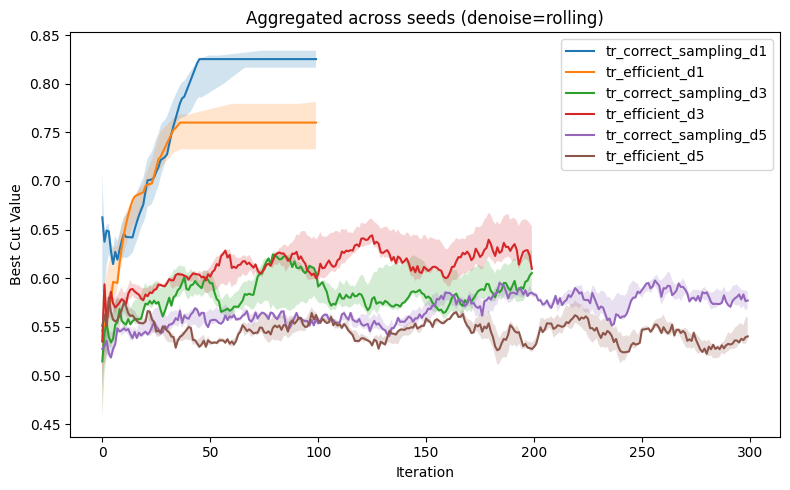

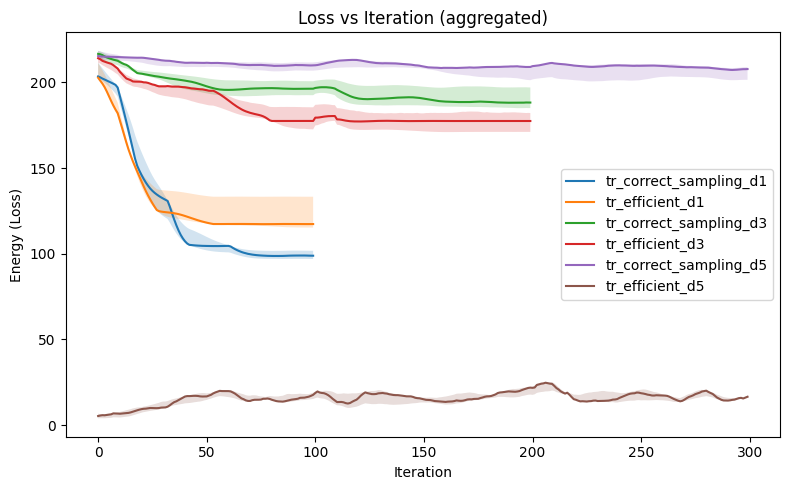

In [25]:
# # Suppose you have several seeds for each depth
# method_to_runids = {
#     "tr_efficient_d1": [ "run_id_seed1", "run_id_seed2", "run_id_seed3" ],
#     "tr_efficient_d2": [ "run_id_seed1", "run_id_seed2" ],
#     "tr_efficient_d3": [ "run_id_seed1", "run_id_seed2", "run_id_seed3" ],
# }
N_list = [4, 8, 16, 24, 36, 52, 70, 90, 100]
i =5
N = N_list[i]
graph_lookup = {(g['N'], g['graph_id']): g['G'] for g in exp_grid_loaded}
print(N)
all_methods = ['tr_efficient', 'tr_correct_sampling']
method_to_runids = get_method_to_runids(
    outdir="bench_out_52",
    methods=  ['tr_efficient', 'tr_correct_sampling'],
    depths=[1,3,5],
    N=N
)
plot_compare_best_cut_aggregated(
    method_to_runids,
    cut_off_it=300,
    denoise="rolling",
    rolling_window=20,
    outdir="bench_out_52",
    all_graph=exp_grid_loaded
)
# plot aggregated loss curves
plot_compare_loss_aggregated(
    method_to_runids,
    cut_off_it=300,
    denoise="rolling",
    rolling_window=10,
    ylabel="Energy (Loss)",
    outdir="bench_out_52",
    all_graph=exp_grid_loaded
)


In [17]:
with open("experiment_grid.json", "r") as f:
    loaded = json.load(f)

# Convert lists back to tuples if you want
def convert_lists_to_tuples(obj):
    if isinstance(obj, list):
        # Check if list looks like an edge [(0,1), w]
        if len(obj) == 2 and isinstance(obj[0], list) and isinstance(obj[1], (int, float)):
            return (tuple(obj[0]), obj[1])
        else:
            return [convert_lists_to_tuples(x) for x in obj]
    if isinstance(obj, dict):
        return {k: convert_lists_to_tuples(v) for k, v in obj.items()}
    return obj

exp_grid_loaded = [convert_lists_to_tuples(entry) for entry in loaded]

print(exp_grid_loaded[0])  # should match your original structure
# {'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


{'N': 4, 'graph_id': 0, 'seed': 45854826, 'G': [((0, 3), 3), ((0, 2), 1), ((0, 1), 5), ((1, 2), 7), ((1, 3), 8), ((2, 3), 8)], 'depth': 1}


In [18]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# parse keys like "tr_correct_sampling_d5_s2" -> ("tr_correct_sampling", 5, 2)
_key_re = re.compile(r"(.+)_d(\d+)_s(\d+)$")
def _parse_key(k: str):
    m = _key_re.match(k)
    return (m.group(1), int(m.group(2)), int(m.group(3))) if m else (k, None, None)

def _collect_runs(methods_to_runids, run_meta):
    """
    Returns: by_ND[ (N,D) ][ base_method ] = [run_ids...]
    """
    by_ND = defaultdict(lambda: defaultdict(list))
    for key, runids in methods_to_runids.items():
        base, D, _ = _parse_key(key)
        for rid in runids:
            meta = run_meta[rid]
            N = meta["N"]
            DD = meta.get("depth", D)
            by_ND[(N, DD)][base].append(rid)
    return by_ND

def _norm_ratio(y, gm):
    if gm is None or gm == 0: return None
    return y / gm

def plot_grid_by_N_and_D(
    methods_to_runids: dict,
    run_meta: dict,
    aggregate_over_seeds,
    *,
    g=None,
    Ns=(4,8,16,24),
    Ds=(1,3,5),
    denoise="running_best",
    rolling_window=10,
    cut_off_it=100,
    outdir="bench_out",
    method_names=("tr_correct_sampling","tr_efficient"),
    method_labels=None,  # e.g. {"tr_correct_sampling":"TR-Correct (sampling)","tr_efficient":"TR-Contraction"}
):
    """
    Produces two figures:
      Fig A: BestCut / Gurobi vs Iteration, grid rows=N, cols=D
      Fig B: Loss vs Iteration, same grid
    """
    by_ND = _collect_runs(methods_to_runids, run_meta)
    if method_labels is None:
        method_labels = {m:m for m in method_names}

    # ---------- Figure A: BestCut normalized ----------
    figA, axesA = plt.subplots(len(Ns), len(Ds), figsize=(4.6*len(Ds), 3.4*len(Ns)), sharex=True, sharey=True)
    if len(Ns) == 1 and len(Ds) == 1:
        axesA = np.array([[axesA]])

    for i, N in enumerate(Ns):
        for j, D in enumerate(Ds):
            ax = axesA[i, j]
            cell = by_ND.get((N, D), {})
            # Optional: draw y=1 optimal line
            ax.plot(range(cut_off_it), [1.0]*cut_off_it, "--", linewidth=1, label="Optimal" if (i==0 and j==0) else None)

            for k, base_method in enumerate(method_names):
                run_ids = cell.get(base_method, [])
                if not run_ids: 
                    continue
                iters, med, q25, q75 = aggregate_over_seeds(
                    run_ids, g, cut_off_it, denoise=denoise,
                    rolling_window=rolling_window, outdir=outdir
                )

                # Normalize by each run's gurobi_max first, then aggregate (safer across heterogeneous graphs)
                # If your aggregate_over_seeds already aggregated across runs, do per-run normalization instead.
                # Here, we approximate by using the median curve's graph; for rigor, switch to per-run normalization before aggregating.
                # Quick robust version: recompute per-run and stack.
                curves = []
                x_common = np.array(iters)
                for rid in run_ids:
                    gm = run_meta[rid].get("gurobi_max")
                    it2, med2, _, _ = aggregate_over_seeds(
                        [rid], g, cut_off_it, denoise=denoise,
                        rolling_window=rolling_window, outdir=outdir
                    )
                    y_norm = _norm_ratio(np.asarray(med2, float), gm)
                    if y_norm is not None:
                        L = min(len(x_common), len(y_norm))
                        curves.append(y_norm[:L])
                        x_common = x_common[:L]
                if not curves:
                    continue
                A = np.vstack(curves)
                medN = np.median(A, axis=0)
                q25N = np.percentile(A, 25, axis=0)
                q75N = np.percentile(A, 75, axis=0)

                lab = method_labels.get(base_method, base_method)
                ax.plot(x_common, medN, label=lab if (i==0 and j==0) else None)
                ax.fill_between(x_common, q25N, q75N, alpha=0.18)

            if i == len(Ns)-1:
                ax.set_xlabel("Iteration")
            if j == 0:
                ax.set_ylabel("Best Cut / Optimal")
            ax.set_title(f"N={N}, D={D}")

    handles, labels = axesA[0,0].get_legend_handles_labels()
    if handles:
        figA.legend(handles, labels, loc="upper center", ncol=len(method_names)+1)
    figA.suptitle("Best Cut (normalized) vs Iteration")
    figA.tight_layout(rect=[0,0,1,0.93])

    # ---------- Figure B: Loss ----------
    figB, axesB = plt.subplots(len(Ns), len(Ds), figsize=(4.6*len(Ds), 3.4*len(Ns)), sharex=True, sharey=False)
    if len(Ns) == 1 and len(Ds) == 1:
        axesB = np.array([[axesB]])

    for i, N in enumerate(Ns):
        for j, D in enumerate(Ds):
            ax = axesB[i, j]
            cell = by_ND.get((N, D), {})
            for base_method in method_names:
                run_ids = cell.get(base_method, [])
                if not run_ids:
                    continue
                iters, med, q25, q75 = aggregate_over_seeds(
                    run_ids, g, cut_off_it, denoise=denoise,
                    rolling_window=rolling_window, outdir=outdir
                )
                lab = method_labels.get(base_method, base_method)
                ax.plot(iters, med, label=lab if (i==0 and j==0) else None)
                ax.fill_between(iters, q25, q75, alpha=0.18)
            if i == len(Ns)-1:
                ax.set_xlabel("Iteration")
            if j == 0:
                ax.set_ylabel("Energy (Loss)")
            ax.set_title(f"N={N}, D={D}")

    handles, labels = axesB[0,0].get_legend_handles_labels()
    if handles:
        figB.legend(handles, labels, loc="upper center", ncol=len(method_names))
    figB.suptitle("Loss vs Iteration")
    figB.tight_layout(rect=[0,0,1,0.93])

    plt.show()


In [19]:
method_to_runids = get_method_to_runids(
    outdir="bench_out_4816",
    methods=  ['tr_efficient', 'tr_correct_sampling'],
    depths=[1,3,5],
    N=N
)
plot_grid_by_N_and_D(
    method_to_runids,
    run_meta,
    aggregate_over_seeds,
    Ns=[4,8,16,24],
    Ds=[1,3,5],
    cut_off_it=100,
    denoise="rolling",
    rolling_window=10,
    outdir="bench_out_4816",
    method_labels={
        "tr_correct_sampling":"TR-Correct (sampling)",
        "tr_efficient":"TR-Contraction"
    }
)


NameError: name 'run_meta' is not defined

In [20]:
def get_labels_from_summary(run_ids: list[str], summary_csv: str = "bench_out/summary.csv") -> list[str]:
    summary = read_summary(summary_csv)
    label_map = {row["run_id"]: row["method"] + " D = " + row['depth'] for row in summary}
    return [label_map.get(rid, rid) for rid in run_ids]
i = 1
N = N_list[i]
print(N)
# 2) Compare methods at same N/seed using summary.csv
rids = find_runs("bench_out/summary.csv", method=None, N=N, seed=0)
labels = get_labels_from_summary(rids, "bench_out/summary.csv")
plot_compare_loss(rids, labels=labels, cut_off_it=100) 
plot_compare_best_cut(rids, labels=labels, gurobi_max= maxcut_value(loaded_graphs[i]), g=loaded_graphs[i], cut_off_it=100, denoise="rolling", rolling_window=5)

8


FileNotFoundError: [Errno 2] No such file or directory: 'bench_out/summary.csv'

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

def get_final_values_by_method(N: int, g, summary_csv="bench_out/summary.csv"):
    """
    For a given problem size N, collect final exp_values for each method across seeds.
    Returns: dict {method: [final values...]}.
    """
    rows = read_summary(summary_csv)
    values = {}
    for row in rows:
        if row["N"] != N:
            continue
        method = row["method"]
        rid = row["run_id"]
        data = read_iter_csv(rid)
        final_val = data["best_results"][-1]
        final_val = compute_maxcut_value(final_val, g)  # convert bitstring to cut value
        values.setdefault(method, []).append(final_val)
    return values
def plot_final_ratio_vs_N(
    N_list,
    gurobi_ref,
    g,
    summary_csv="bench_out/summary.csv",
    methods_order=None,
    colors=None,
    use_best=True,   # if True, use best value in exp_values instead of just last
):
    """
    Plot method performance normalized by Gurobi value.
    Ratio = best_or_final_value / gurobi_value
    """
    methods = set()
    stats = {}

    for N,g_elm in zip(N_list,g):
        vals = get_final_values_by_method(N, g_elm, summary_csv)
        for m, arr in vals.items():
            methods.add(m)
            # Normalize values
            g_val = gurobi_ref[N]
            norm_arr = [v / g_val for v in arr]
            mean = np.mean(norm_arr)
            std = np.std(norm_arr)
            stats.setdefault(m, {"N": [], "mean": [], "std": []})
            stats[m]["N"].append(N)
            stats[m]["mean"].append(mean)
            stats[m]["std"].append(std)

    methods = list(methods_order or sorted(methods))
    colors = colors or plt.cm.tab10.colors

    plt.figure(figsize=(8, 5))
    for i, m in enumerate(methods):
        d = stats[m]
        plt.errorbar(
            d["N"],
            d["mean"],
            yerr=d["std"],
            marker="o",
            capsize=4,
            label=m,
            color=colors[i % len(colors)]
        )

    # Gurobi baseline = 1 for all N
    Ns = sorted(gurobi_ref.keys())
    plt.plot(Ns, [1.0]*len(Ns), color="black", linestyle="--", marker="s", label="Gurobi (100%)")

    plt.xlabel("MaxCut Graph Size (# nodes)")
    plt.ylabel("Performance Ratio (Method / Gurobi)")
    plt.title("Final performance ratio by method vs. graph size")
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
import torch
import numpy as np
import json
import os

num_params = 100          # number of parameters in your ansatz
seeds = list(range(10))       # 10 seeds: 0..9
save_dir = "theta_inits"      # folder to save all
os.makedirs(save_dir, exist_ok=True)

for seed in seeds:
    g = torch.Generator(device="cpu").manual_seed(seed)
    # Uniform angle in [-π, π]
    theta_init = (2 * torch.pi) * torch.rand(num_params, generator=g) - torch.pi

    # Save tensor
    torch.save(theta_init, f"{save_dir}/theta_init_s{seed}_extra.pt")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def _match_depth(row, depth_filter):
    """
    Return True if the row passes the depth filter.
    Tries common keys: 'depth', 'D', 'ansatz_depth'.
    """
    if depth_filter is None:
        return True

    # Try to discover a depth-like field
    depth = None
    for k in ("depth", "D", "ansatz_depth"):
        if k in row:
            depth = row[k]
            break

    # If no depth field found, only pass when filter is None (already handled)
    if depth is None:
        return False

    # Callable for custom logic
    if callable(depth_filter):
        return bool(depth_filter(row))

    # Exact integer
    if isinstance(depth_filter, int):
        return int(depth) == depth_filter

    # Range tuple (min, max), inclusive
    if isinstance(depth_filter, tuple) and len(depth_filter) == 2:
        lo, hi = depth_filter
        return (lo is None or depth >= lo) and (hi is None or depth <= hi)

    # Iterable set/list of allowed depths
    try:
        return int(depth) in set(depth_filter)
    except Exception:
        return False


def get_final_values_by_method(
    N: int,
    g,
    summary_csv="bench_out/summary.csv",
    *,
    use_best: bool = True,
    depth_filter=None,
):
    """
    For a given N (graph size), collect per-method MaxCut *cut values* (not energy),
    optionally filtered by circuit depth.

    - If use_best=True: use the best cut found over all iterations for each run.
    - Else: use the final iteration's best_result (bitstring) only.
    """
    rows = read_summary(summary_csv)
    values = {}
    for row in rows:
        if row.get("N") != N:
            continue
        if not _match_depth(row, depth_filter):
            continue

        method = row["method"]
        rid = row["run_id"]
        data = read_iter_csv(rid)

        if use_best:
            # best over trajectory
            best_over_time = -np.inf
            for b in data.get("best_results", []):
                if b is None:
                    continue
                try:
                    cut_val = compute_maxcut_value(b, g)
                except Exception:
                    continue
                if cut_val > best_over_time:
                    best_over_time = cut_val
            if np.isfinite(best_over_time):
                values.setdefault(method, []).append(best_over_time)
        else:
            # final-only
            b = data.get("best_results", [None])[-1]
            if b is None:
                continue
            try:
                final_cut = compute_maxcut_value(b, g)
                values.setdefault(method, []).append(final_cut)
            except Exception:
                continue

    return values


def plot_final_ratio_vs_N(
    N_list,
    gurobi_ref,   # dict {N: gurobi_cut_value}
    g_list,       # list of graphs aligned with N_list
    summary_csv="bench_out/summary.csv",
    methods_order=None,
    colors=None,
    use_best=True,      # True: best over iters; False: final only
    depth_filter=None,  # see _match_depth() for accepted forms
):
    """
    Plot method performance normalized by Gurobi: ratio = method_cut / gurobi_cut.
    Applies an optional depth filter to include only runs matching the desired depth.
    """
    assert len(N_list) == len(g_list), "N_list and g_list must have the same length"

    methods = set()
    stats = {}

    for N, g in zip(N_list, g_list):
        vals = get_final_values_by_method(
            N,
            g,
            summary_csv=summary_csv,
            use_best=use_best,
            depth_filter=depth_filter,
        )
        if N not in gurobi_ref or gurobi_ref[N] is None or gurobi_ref[N] == 0:
            # Skip if no valid reference for this N
            continue
        g_val = float(gurobi_ref[N])

        for m, arr in vals.items():
            if not arr:
                continue
            methods.add(m)
            norm_arr = [v / g_val for v in arr if np.isfinite(v)]
            if not norm_arr:
                continue
            mean = float(np.mean(norm_arr))
            std  = float(np.std(norm_arr))
            slot = stats.setdefault(m, {"N": [], "mean": [], "std": []})
            slot["N"].append(N)
            slot["mean"].append(mean)
            slot["std"].append(std)

    if not methods:
        print("No data to plot after applying filters.")
        return

    methods = list(methods_order or sorted(methods))
    colors = colors or plt.cm.tab10.colors

    plt.figure(figsize=(8, 5))
    for i, m in enumerate(methods):
        if m not in stats:
            continue
        d = stats[m]
        # Sort by N to draw clean lines
        order = np.argsort(d["N"])
        Ns = np.array(d["N"])[order].tolist()
        means = np.array(d["mean"])[order].tolist()
        stds  = np.array(d["std"])[order].tolist()

        plt.errorbar(
            Ns,
            means,
            yerr=stds,
            marker="o",
            capsize=4,
            label=m,
            color=colors[i % len(colors)]
        )

    # Baseline at 1.0
    Ns_all = sorted(n for n in gurobi_ref.keys() if n in N_list)
    if Ns_all:
        plt.plot(Ns_all, [1.0]*len(Ns_all), linestyle="--", marker="s", color="black", label="Gurobi (100%)")

    plt.xlabel("MaxCut Graph Size (# nodes)")
    plt.ylabel("Performance Ratio (Method / Gurobi)")
    title_suffix = "best-so-far" if use_best else "final-only"
    # Show depth filter in the title, if any
    if depth_filter is None:
        depth_txt = ""
    elif isinstance(depth_filter, int):
        depth_txt = f" • depth={depth_filter}"
    elif isinstance(depth_filter, tuple) and len(depth_filter) == 2:
        depth_txt = f" • depth∈[{depth_filter[0]}, {depth_filter[1]}]"
    else:
        depth_txt = " • depth filtered"

    plt.title(f"Performance ratio vs. graph size ({title_suffix}){depth_txt}")
    plt.ylim(bottom=0)
    plt.legend()
    plt.tight_layout()
    plt.show()


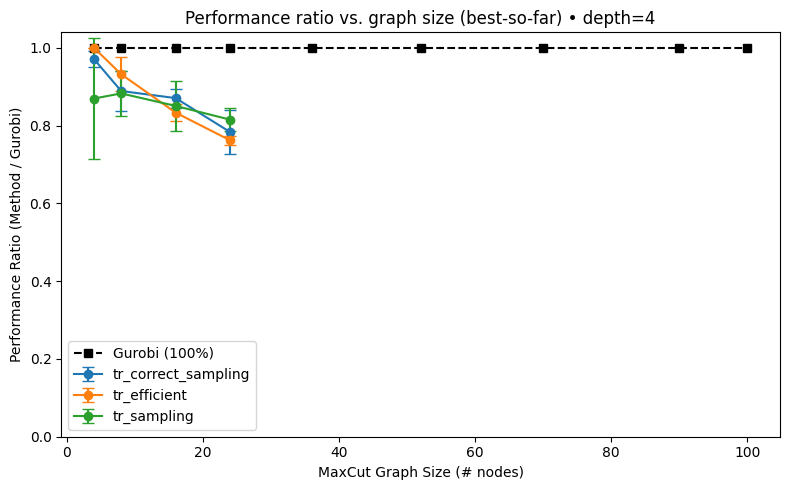

In [ ]:
N_list = [4, 8, 16, 24, 36, 52, 70, 90, 100]
gurobi_ref = {}
for n, g in zip(N_list, loaded_graphs[:len(N_list)]):
    gurobi_ref[n] = maxcut_value(g)

plot_final_ratio_vs_N(N_list, gurobi_ref, g_list=loaded_graphs[:len(N_list)], summary_csv="bench_out/summary.csv", depth_filter=4)


In [ ]:
theta_init = torch.load("theta_init_S0.pt")
print(theta_init[0])
theta_init = torch.load("theta_init_S2.pt")
print(theta_init[0])

tensor(-0.1126)
tensor(-0.1041)


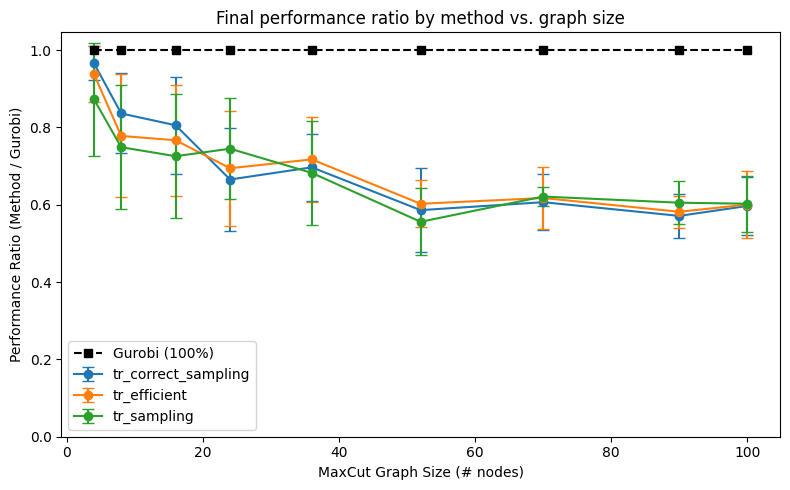

In [ ]:
# Suppose you ran 5 seeds each for N=6,8,10,12
N_list = [4, 8, 16, 24, 36, 52, 70, 90, 100]
gurobi_ref = {}
for n, g in zip(N_list, loaded_graphs[:len(N_list)]):
    gurobi_ref[n] = maxcut_value(g)


plot_final_ratio_vs_N(N_list, gurobi_ref, g=loaded_graphs[:len(N_list)], summary_csv="bench_out/summary.csv")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers ---------------------------------------------------------------
def _running_min(a: np.ndarray) -> np.ndarray:
    out = np.empty_like(a, dtype=float)
    m = np.inf
    for i, v in enumerate(a):
        if v < m: m = v
        out[i] = m
    return out

def _read_runs_for(N, method, summary_csv="bench_out/summary.csv", outdir="bench_out"):
    """Returns list of exp_value arrays (one per seed) for (N, method)."""
    rids = find_runs(summary_csv, method=method, N=N)
    curves = []
    for rid in rids:
        d = read_iter_csv(rid, outdir)
        curves.append(np.asarray(d["exp_values"], dtype=float))
    return curves  # list of (T_i,)

def _align_curves(curves, align="minlen"):
    """Trim/align to same length for averaging."""
    if not curves: return np.empty((0,)), []
    if align == "minlen":
        T = min(len(c) for c in curves)
        return np.stack([c[:T] for c in curves]), list(range(T))
    # fallback: pad with last value
    T = max(len(c) for c in curves)
    pad = []
    for c in curves:
        if len(c) < T:
            tail = np.full(T - len(c), c[-1])
            pad.append(np.concatenate([c, tail]))
        else:
            pad.append(c)
    return np.stack(pad), list(range(T))

# ---- 1) Small-multiples: running-min (or normalized) per N -----------------
def plot_running_min_by_N(
    N_list,
    methods=("tr_efficient","tr_correct_sampling","tr_sampling"),
    summary_csv="bench_out/summary.csv",
    outdir="bench_out",
    normalize=False,          # if True, divide each curve by its initial value
    sharey=True
):
    cols = min(4, len(N_list))
    rows = int(np.ceil(len(N_list)/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.2*cols, 3.2*rows), sharex=False, sharey=sharey)
    axes = np.atleast_1d(axes).ravel()

    for ax, N in zip(axes, N_list):
        for mi, m in enumerate(methods):
            curves = _read_runs_for(N, m, summary_csv, outdir)
            if not curves: 
                continue
            # running min per seed
            curves = [ _running_min(c) for c in curves ]
            if normalize:
                curves = [ c / (c[0] if c[0] != 0 else 1.0) for c in curves ]
            arr, it = _align_curves(curves)
            mean, std = arr.mean(axis=0), arr.std(axis=0)
            ax.plot(it, mean, label=m)
            ax.fill_between(it, mean-std, mean+std, alpha=0.2)
        ax.set_title(f"N={N}")
        ax.set_xlabel("iteration")
        ax.set_ylabel("running-min loss" + (" (normalized)" if normalize else ""))
        ax.grid(alpha=0.2)

    # hide unused axes
    for i in range(len(N_list), len(axes)):
        axes[i].axis("off")

    handles, labels = axes[0].get_legend_handles_labels() if len(N_list)>0 else ([],[])
    if labels:
        fig.legend(handles, labels, loc="upper center", ncol=min(3, len(labels)), frameon=False)
    fig.suptitle("Convergence by N (running-min of loss)", y=1.02)
    fig.tight_layout()
    plt.show()

# ---- 2) Iterations-to-target vs N (convergence summary) --------------------
def plot_iters_to_target_vs_N(
    N_list,
    methods=("tr_efficient","tr_correct_sampling","tr_sampling"),
    summary_csv="bench_out/summary.csv",
    outdir="bench_out",
    target_ratio=0.95,   # reach 95% of (initial_loss - best_seen_across_seeds) improvement
):
    """
    For each (N, method): across seeds, find the first iter where running-min
    <= best_seed_min + target_ratio * (initial_seed - best_seed_min).
    Lower is better (fewer iterations).
    """
    plt.figure(figsize=(8,5))
    for m in methods:
        xs, ys, es = [], [], []
        for N in N_list:
            curves = _read_runs_for(N, m, summary_csv, outdir)
            if not curves: 
                continue
            iters_needed = []
            for c in curves:
                c = np.asarray(c, float)
                rm = _running_min(c)
                init, best = c[0], rm[-1]
                # target value: within (1-target_ratio) fraction of total drop
                target = best + (init - best) * (1 - target_ratio)
                k = np.argmax(rm <= target) if np.any(rm <= target) else len(rm)-1
                iters_needed.append(int(k))
            xs.append(N)
            ys.append(np.mean(iters_needed))
            es.append(np.std(iters_needed))
        if xs:
            plt.errorbar(xs, ys, yerr=es, marker="o", capsize=4, label=m)

    plt.xlabel("N (qubits / nodes)")
    plt.ylabel(f"Iterations to {int(target_ratio*100)}% of improvement")
    plt.title("Convergence speed vs N")
    plt.grid(alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- 3) Optional: normalized final loss vs N (mean±std over seeds) ---------
def plot_final_normalized_vs_N(
    N_list,
    methods=("tr_efficient","tr_correct_sampling","tr_sampling"),
    summary_csv="bench_out/summary.csv",
    outdir="bench_out",
):
    plt.figure(figsize=(8,5))
    for m in methods:
        xs, mu, sd = [], [], []
        for N in N_list:
            curves = _read_runs_for(N, m, summary_csv, outdir)
            if not curves: 
                continue
            finals = []
            for c in curves:
                c = np.asarray(c, float)
                # normalized by initial value
                finals.append(c[-1] / (c[0] if c[0] != 0 else 1.0))
            xs.append(N); mu.append(np.mean(finals)); sd.append(np.std(finals))
        if xs:
            plt.errorbar(xs, mu, yerr=sd, marker="o", capsize=4, label=m)

    plt.xlabel("N")
    plt.ylabel("Final loss / initial loss")
    plt.title("Normalized final loss vs N (lower is better)")
    plt.grid(alpha=0.2); plt.legend(); plt.tight_layout(); plt.show()


[{'run_id': 'd4dd18c3', 'method': 'tr_efficient', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_d4dd18c3.pt', 'iter_csv': 'bench_out/iter_d4dd18c3.csv'}, {'run_id': '8fbe4555', 'method': 'tr_correct_sampling', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_8fbe4555.pt', 'iter_csv': 'bench_out/iter_8fbe4555.csv'}, {'run_id': '2be346b9', 'method': 'tr_sampling', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_2be346b9.pt', 'iter_csv': 'bench_out/iter_2be346b9.csv'}, {'run_id': '90240eb1', 'method': 'tr_efficient', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_90240eb1.pt', 'iter_csv': 'bench_out/iter_90240eb1.csv'}, {'run_id': 'fb94ef3e', 'method': 'tr_correct_sampling', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_fb94ef3e.pt', 'iter_csv': 'bench_out/iter_fb94ef3e.csv'}, {'run_id': '371e5963', 'method': 'tr_sampling', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_371e5963.pt', 'iter

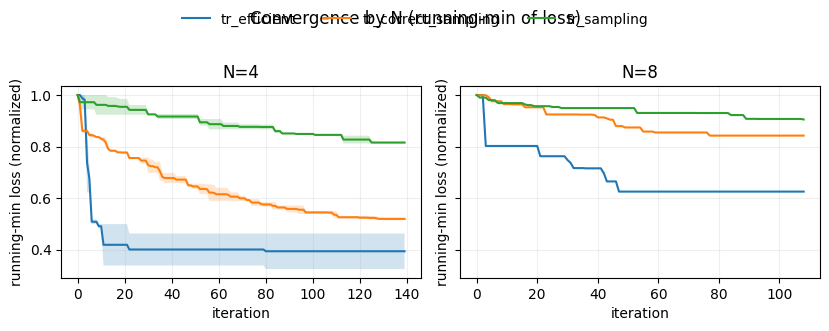

[{'run_id': 'd4dd18c3', 'method': 'tr_efficient', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_d4dd18c3.pt', 'iter_csv': 'bench_out/iter_d4dd18c3.csv'}, {'run_id': '8fbe4555', 'method': 'tr_correct_sampling', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_8fbe4555.pt', 'iter_csv': 'bench_out/iter_8fbe4555.csv'}, {'run_id': '2be346b9', 'method': 'tr_sampling', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_2be346b9.pt', 'iter_csv': 'bench_out/iter_2be346b9.csv'}, {'run_id': '90240eb1', 'method': 'tr_efficient', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_90240eb1.pt', 'iter_csv': 'bench_out/iter_90240eb1.csv'}, {'run_id': 'fb94ef3e', 'method': 'tr_correct_sampling', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_fb94ef3e.pt', 'iter_csv': 'bench_out/iter_fb94ef3e.csv'}, {'run_id': '371e5963', 'method': 'tr_sampling', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_371e5963.pt', 'iter

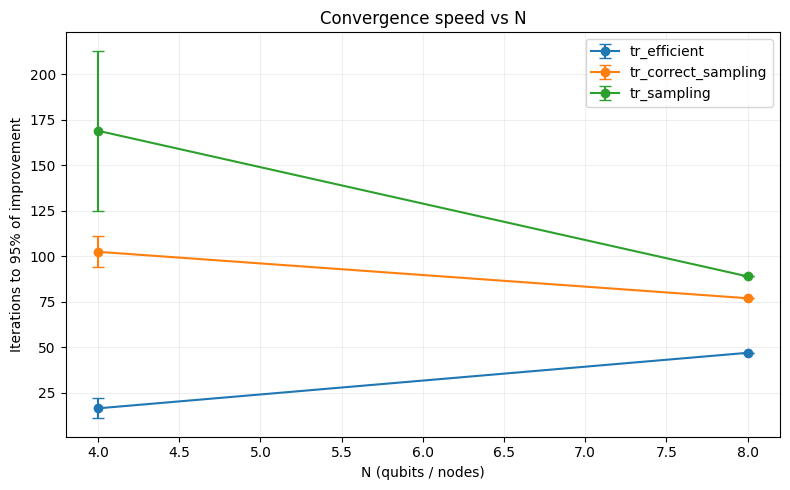

[{'run_id': 'd4dd18c3', 'method': 'tr_efficient', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_d4dd18c3.pt', 'iter_csv': 'bench_out/iter_d4dd18c3.csv'}, {'run_id': '8fbe4555', 'method': 'tr_correct_sampling', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_8fbe4555.pt', 'iter_csv': 'bench_out/iter_8fbe4555.csv'}, {'run_id': '2be346b9', 'method': 'tr_sampling', 'N': 4, 'depth': '5', 'seed': 0, 'theta_path': 'bench_out/theta_2be346b9.pt', 'iter_csv': 'bench_out/iter_2be346b9.csv'}, {'run_id': '90240eb1', 'method': 'tr_efficient', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_90240eb1.pt', 'iter_csv': 'bench_out/iter_90240eb1.csv'}, {'run_id': 'fb94ef3e', 'method': 'tr_correct_sampling', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_fb94ef3e.pt', 'iter_csv': 'bench_out/iter_fb94ef3e.csv'}, {'run_id': '371e5963', 'method': 'tr_sampling', 'N': 4, 'depth': '5', 'seed': 1, 'theta_path': 'bench_out/theta_371e5963.pt', 'iter

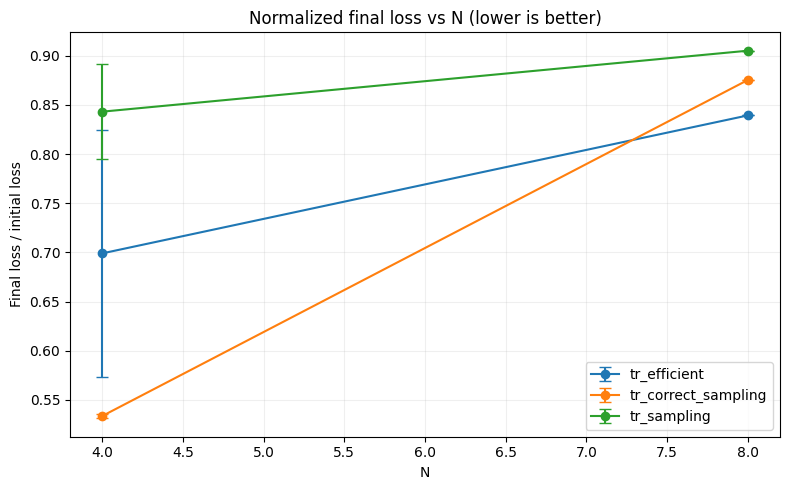

In [ ]:
Ns = [4,8]  # whatever you ran
# 1) Faceted convergence curves (mean±std across seeds)
plot_running_min_by_N(Ns, normalize=True)

# 2) Convergence speed summary (iterations needed to get close to best)
plot_iters_to_target_vs_N(Ns, target_ratio=0.95)

# 3) Final normalized loss vs N
plot_final_normalized_vs_N(Ns)


In [ ]:
import torch
from torch.autograd import Function
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit import QuantumCircuit

def run_circuit_sv(theta,N,D,h, isRing):
    c = QuantumCircuit(N)
    theta_t = 0
    for i in range(D):
        for ind1 in range(N):
            c.rx(theta[theta_t].detach().cpu().item(), ind1)
            theta_t+=1
        for ind1 in range(N):
            c.rz(theta[theta_t].detach().cpu().item(), ind1)
            theta_t+=1
        for ind1 in range(N-1):
            c.cx(ind1, ind1+1)
        if isRing:
            c.cx(N-1,0)  # Add a CX to make it more complex
    sv = Statevector(c).expectation_value(h)
    return sv.real
def get_opt_cut_sv(theta,N,D,h, isRing):
    c = QuantumCircuit(N)
    t = 0
    for i in range(D):
        for j in range(N):
            c.rx(theta[t].detach().cpu().item(), j)
            t+=1
        for j in range(N):
            c.rz(theta[t].detach().cpu().item(), j)
            t+=1
        for j in range(N-1):
            c.cx(j, j+1)
        if isRing:
            c.cx(N-1,0)  # Add a CX to make it more complex
    sv = Statevector(c)
    my_dict = (sv.probabilities_dict())
    max_key = min(my_dict, key=my_dict.get)
    #print("min key" , max_key)
    probabilities = np.abs(sv) ** 2
    # Step 2: Get index of highest probabili
    max_index = probabilities.argmax()
    return format(max_index,f'0{N}b')

# Custom PyTorch autograd function
class QuantumFunction(Function):
    @staticmethod
    def forward(ctx, theta, gates, N, h, D, isRing):
        ctx.save_for_backward(theta)
        ctx.gates = gates
        ctx.N = N
        ctx.D = D
        ctx.h = h
        ctx.isRing = isRing
        output = run_circuit_sv(theta.detach(), N,D,h, isRing)
        return torch.tensor([output], dtype=torch.float32)
    @staticmethod
    def backward(ctx, grad_output):
        theta, = ctx.saved_tensors
        grad = parameter_shift_grad_sv(theta.detach(), ctx.gates, ctx.N, ctx.D, ctx.h, ctx.isRing)
        return grad_output *grad, None, None, None, None, None
# Parameter-shift gradient manually
def parameter_shift_grad_sv(params, gates, N, D, h, isRing):
    gradients = np.zeros_like(params)
    shift = torch.tensor(torch.pi / 2)
    for i in range(len(params)):
        params_forward = params.clone()
        params_backward = params.clone()
        params_forward[i] += shift
        params_backward[i] -= shift
        gradients[i] = (run_circuit_sv(params_forward,N,D,h, isRing) - run_circuit_sv(params_backward, N,D,h, isRing)) / 2
    return gradients

# Wrap into a PyTorch module
class QuantumCircuitTorch(torch.nn.Module):
    def __init__(self, theta, N, D, h, isRing=True):
        super().__init__()
        self.N = N
        self.D = D
        self.h = h
        self.gates = []
        self.isRing = isRing
        self.theta = torch.nn.Parameter(torch.tensor(theta, requires_grad=False))

    def forward(self):
        return QuantumFunction.apply(self.theta, self.gates, self.N, self.h, self.D, self.isRing)


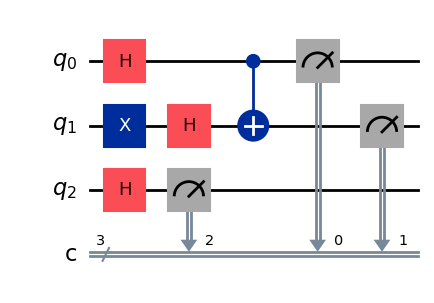

In [ ]:
from qiskit import QuantumCircuit
# Build a quantum circuit
circuit = QuantumCircuit(3, 3)
circuit.x(1)
circuit.h(range(3))
circuit.cx(0, 1)
circuit.measure(range(3), range(3))
# Matplotlib drawing
circuit.draw(output="mpl")

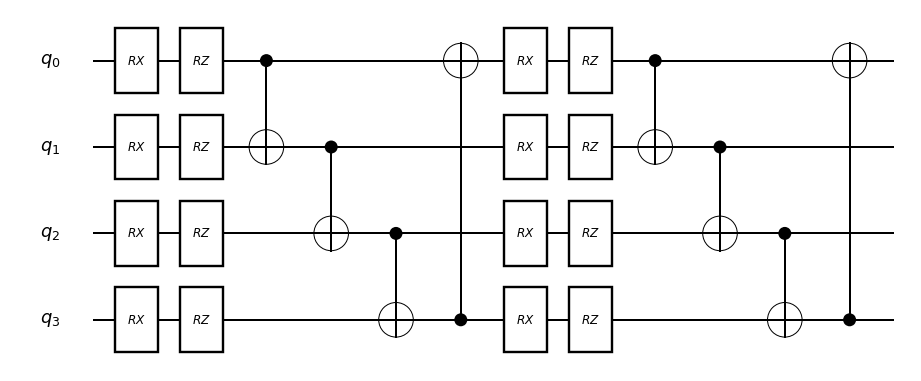

In [ ]:
from qulacs import QuantumCircuit
from qulacsvis import circuit_drawer
# Build a quantum circuit
N = 4
D = 1
circuit = QuantumCircuit(N)
tc = 0
placehoder = 'value'
for i in range(D):
    for j in range(N):
        circuit.add_RotX_gate(j , 0)
        tc += 1
    for j in range(N):
        circuit.add_RotZ_gate(j , 0)
        tc += 1
    for j in range(N-1):
        circuit.add_CNOT_gate(j, j+1)
    circuit.add_CNOT_gate(N-1,0)  # Add a CX to make it more complex 
    circuit.merge_circuit(circuit)
# circuit.add_X_gate(0)
# circuit.add_Y_gate(1)
# circuit.add_Z_gate(2)
# circuit.add_dense_matrix_gate(
#     [0, 1], [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]]
# )
# circuit.add_CNOT_gate(2, 0)
# circuit.add_X_gate(2)

# Draw a quantum circuit
circuit_drawer(circuit, "mpl")

In [ ]:
torch.cuda.empty_cache()